## Carga datos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import time
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, auc, precision_score, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid, cross_validate, RandomizedSearchCV
from skopt import BayesSearchCV
from joblib import Parallel, delayed, dump, load
from tqdm import tqdm
from xgboost import XGBClassifier
import xgboost as xgb
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

sys.path.append('../utils')
from helper_functions import get_results_df


sns.set_theme()
datos_url = '~/freqtrade/dev/local/modelos/datos/btc_curado_28h.csv'
df = pd.read_csv(datos_url, parse_dates=['startDate', 'endDate'])
df['startDate'] = df['startDate'].dt.tz_localize(None)
df['endDate'] = df['endDate'].dt.tz_localize(None)
df.sort_values(by='startDate', inplace=True)
df['label'] = (df['profits'] > 0).astype(int)
df

,startDate,open_1,high_1,low_1,close_1,volume_1,open_2,high_2,low_2,close_2,...,open_28,high_28,low_28,close_28,volume_28,endDate,profits,profit_curado,pair,label
61229,2018-01-01 05:00:00,0.040899,0.018919,0.029714,0.008338,-0.072248,0.008339,0.019709,0.027097,0.030132,...,0.007856,0.000883,0.002419,0.014242,-0.188722,2018-01-01 11:00:00,-0.024960,0,BTC,0
61232,2018-01-01 06:00:00,0.008339,0.019709,0.027097,0.030132,-0.029160,0.030319,0.000822,0.000000,-0.028882,...,0.013414,0.005557,0.015339,-0.003089,0.186093,2018-01-01 08:00:00,-0.020349,0,BTC,0
61228,2018-01-01 07:00:00,0.030319,0.000822,0.000000,-0.028882,-0.031162,-0.027113,-0.027869,-0.007394,-0.002895,...,-0.005597,0.007373,-0.001220,0.016330,-0.344457,2018-01-01 11:00:00,-0.025776,0,BTC,0
61227,2018-01-01 08:00:00,-0.027113,-0.027869,-0.007394,-0.002895,-0.196567,-0.004889,0.003122,-0.012152,-0.021242,...,0.017800,0.001344,0.003332,-0.015243,0.102642,2018-01-01 11:00:00,-0.020699,0,BTC,0
61230,2018-01-01 09:00:00,-0.004889,0.003122,-0.012152,-0.021242,-0.094780,-0.021242,-0.019114,-0.011190,-0.008504,...,-0.015241,-0.006029,-0.011436,-0.005185,-0.069733,2018-01-01 11:00:00,-0.029113,0,BTC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2024-12-31 11:00:00,0.003417,-0.001195,-0.002111,-0.001807,0.218175,-0.001806,0.000205,0.004322,0.001274,...,0.000963,0.001272,-0.001782,0.000955,0.029581,2025-01-02 10:00:00,0.026268,1,BTC,1
0,2024-12-31 12:00:00,-0.001806,0.000205,0.004322,0.001274,-0.515876,0.001274,0.000603,-0.000391,0.000439,...,0.000955,0.000147,0.003416,0.001264,-0.244622,2025-01-02 11:00:00,0.023198,1,BTC,1
35,2024-12-31 13:00:00,0.001274,0.000603,-0.000391,0.000439,0.231204,0.000440,0.000476,0.000473,-0.001055,...,0.001264,0.007146,0.002646,0.003260,1.317895,2024-12-31 17:00:00,-0.015339,0,BTC,0
36,2024-12-31 14:00:00,0.000440,0.000476,0.000473,-0.001055,-0.338317,-0.001055,-0.001228,-0.002789,0.001385,...,0.003260,0.011541,0.003096,0.011078,0.440290,2024-12-31 17:00:00,-0.016286,0,BTC,0


In [2]:
df = df.drop(df.filter(regex='^volume').columns, axis=1)
exclude_cols = ['endDate', 'startDate', 'profits', 'profit_curado', 'label', 'pair']

df_dev = df[(df.startDate < pd.to_datetime('2024-01-01')) & (df.startDate >= pd.to_datetime('2020-01-01'))]
df_test = df[df.startDate >= pd.to_datetime('2024-01-01')]

X_dev, y_dev = df_dev.drop(exclude_cols,axis=1), df_dev['profit_curado']
X_test, y_test = df_test.drop(exclude_cols,axis=1), df_test['profit_curado']

X_dev.shape, X_test.shape

((35032, 112), (8776, 112))

## Entrenamiento

In [30]:
tscv = TimeSeriesSplit(n_splits=5, gap=100)

search_space = {'eta': (0.01,0.2,'log-uniform'),
                'n_estimators':(50,350),
                'max_depth':(2,4),
                'gamma':(0.01, 0.1),
                'subsample':(0.5,0.9),
                'alpha':(35,65),
                'lambda':(25,75) 
               }

search_space_2 = {'eta': (0.01,0.2,'log-uniform'),
                  'n_estimators':(50,350),
                  'max_depth':(2,4),
                  'gamma':(0.01,0.1),
                  'subsample':(0.5,0.9),
                  'alpha':(30,50),
                  'lambda':(50,100)
                  }

search_space_3 = {'eta': (0.01,0.2,'log-uniform'),
                  'n_estimators':(50,350),
                  'max_depth':(5,10),
                  'subsample':(0.5,0.9),
                  'alpha':(0,10),
                  'lambda':(0,10)
                  }

xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc')

opt_roc = BayesSearchCV(xgb, search_space_3, n_iter=20, return_train_score=True, scoring='roc_auc',
                        cv=tscv, random_state=42, n_jobs=8, n_points=5, verbose=0)

opt_acc = BayesSearchCV(xgb, search_space_3, n_iter=20, return_train_score=True, scoring='accuracy',
                        cv=tscv, random_state=42, n_jobs=8, n_points=5, verbose=0)

opt_logloss = BayesSearchCV(xgb, search_space_2, n_iter=30, return_train_score=True, scoring='neg_log_loss',
                            cv=tscv, random_state=42, n_jobs=8, n_points=5, verbose=0)

#opt_pr = BayesSearchCV(xgb, search_space_2, n_iter=30, return_train_score=True, scoring='average_precision',
#                       cv=tscv, random_state=42, n_jobs=1, n_points=2, verbose=0)

In [31]:
start_time = time.time()

# Optimizando ROC-AUC
opt_roc.fit(X_dev, y_dev)
res_roc = get_results_df(opt_roc)

opt_acc.fit(X_dev, y_dev)
res_acc = get_results_df(opt_acc)
# Optimizando PR-AUC
#opt_pr.fit(X_dev, y_dev)
#res_pr = get_results_df(opt_pr)

#opt_logloss.fit(X_dev, y_dev)
#res_logloss = get_results_df(opt_logloss)

print(f"Total time: {(time.time()-start_time)/60:.2f}m")
res_acc[:10]

Total time: 12.69m


,mean_test_score,mean_train_score,params,alpha,eta,lambda,max_depth,n_estimators,subsample
rank_test_score,,,,,,,,,
1,0.588832,0.585276,"{'alpha': 10, 'eta': 0.01, 'lambda': 10, 'max_...",10,0.010000,10,5,50,0.500000
2,0.588284,0.593496,"{'alpha': 10, 'eta': 0.01, 'lambda': 0, 'max_d...",10,0.010000,0,5,50,0.900000
3,0.586399,0.601401,"{'alpha': 2, 'eta': 0.01, 'lambda': 0, 'max_de...",2,0.010000,0,5,50,0.760907
4,0.582768,0.664466,"{'alpha': 10, 'eta': 0.01, 'lambda': 0, 'max_d...",10,0.010000,0,10,87,0.500000
5,0.582665,0.617083,"{'alpha': 8, 'eta': 0.014720628941871417, 'lam...",8,0.014721,0,6,51,0.557625
6,0.577835,0.613019,"{'alpha': 10, 'eta': 0.01, 'lambda': 7, 'max_d...",10,0.010000,7,5,123,0.858790
7,0.569921,0.709318,"{'alpha': 10, 'eta': 0.01, 'lambda': 5, 'max_d...",10,0.010000,5,9,208,0.611551
8,0.569373,0.654803,"{'alpha': 8, 'eta': 0.03202450930370514, 'lamb...",8,0.032025,6,6,64,0.770662
9,0.559541,0.756088,"{'alpha': 8, 'eta': 0.025155675267842837, 'lam...",8,0.025156,2,8,124,0.690286


In [32]:
res_roc[:10]

,mean_test_score,mean_train_score,params,alpha,eta,lambda,max_depth,n_estimators,subsample
rank_test_score,,,,,,,,,
1,0.524227,0.930657,"{'alpha': 0, 'eta': 0.01489396044907854, 'lamb...",0,0.014894,0,8,126,0.544722
2,0.523845,0.717043,"{'alpha': 0, 'eta': 0.026539504280904496, 'lam...",0,0.026540,0,5,50,0.898882
3,0.523734,0.732150,"{'alpha': 1, 'eta': 0.013910231499999431, 'lam...",1,0.013910,10,5,166,0.634787
4,0.523675,0.738870,"{'alpha': 1, 'eta': 0.010387456629332565, 'lam...",1,0.010387,3,5,209,0.596012
5,0.522266,0.865720,"{'alpha': 0, 'eta': 0.018569957535127125, 'lam...",0,0.018570,0,5,350,0.873781
6,0.522128,0.806746,"{'alpha': 5, 'eta': 0.02950310506615914, 'lamb...",5,0.029503,7,6,111,0.733920
7,0.521932,0.700485,"{'alpha': 9, 'eta': 0.0100290772479226, 'lambd...",9,0.010029,2,5,129,0.874115
8,0.521614,0.954434,"{'alpha': 0, 'eta': 0.01, 'lambda': 7, 'max_de...",0,0.010000,7,10,88,0.745207
9,0.520511,0.761996,"{'alpha': 8, 'eta': 0.03202450930370514, 'lamb...",8,0.032025,6,6,64,0.770662


## Evaluacion

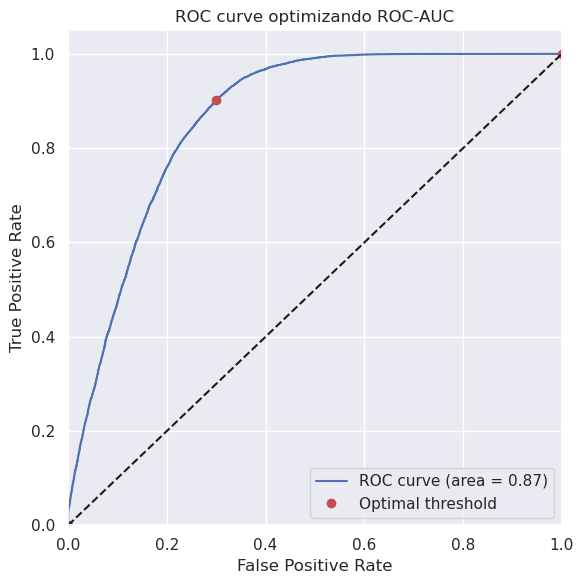

In [27]:
clf_roc = XGBClassifier(**res_roc.iloc[0,:].params, objective='binary:logistic', eval_metric='auc')
clf_roc.fit(X_dev, y_dev)
y_probas_roc = clf_roc.predict_proba(X_dev)[:,1]
y_probas_test = clf_roc.predict_proba(X_test)[:,1]

fpr_roc, tpr_roc, thresholds_roc = roc_curve(y_dev, y_probas_roc)
optimal_threshold_roc = thresholds_roc[np.argmax(tpr_roc-fpr_roc)]
fpr_optimal_roc, tpr_optimal_roc, _ = roc_curve(y_dev, y_probas_roc > optimal_threshold_roc)
roc_auc_roc = roc_auc_score(y_dev, y_probas_roc)

# Create a figure with two subplots
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

# Plot ROC curve for clf_roc
axs.plot(fpr_roc, tpr_roc, label='ROC curve (area = %0.2f)' % roc_auc_roc)
axs.plot(fpr_optimal_roc, tpr_optimal_roc, 'ro', label='Optimal threshold')  
axs.plot([0, 1], [0, 1], 'k--')
axs.set_xlim([0.0, 1.0])
axs.set_ylim([0.0, 1.05])
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.set_title('ROC curve optimizando ROC-AUC')
axs.legend(loc="lower right")

# Display the figure
plt.tight_layout()
plt.show()

In [28]:
optimal_threshold_roc

0.43554866

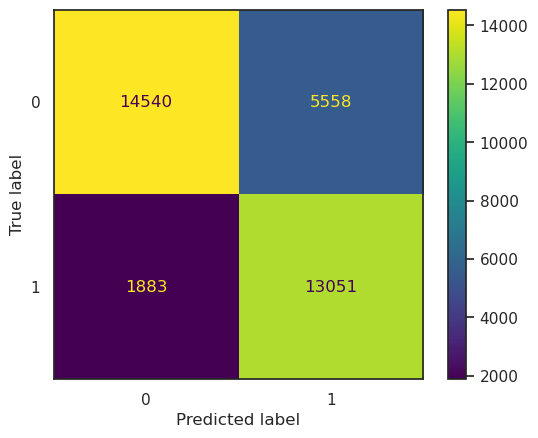

In [29]:
y_pred_train = y_probas_roc > 0.44
sns.set_style("white")
disp = ConfusionMatrixDisplay.from_predictions(y_dev, y_pred)

In [15]:
dump(clf_roc, '../models/xgb_overfit.pkl')

['../models/xgb_overfit.pkl']

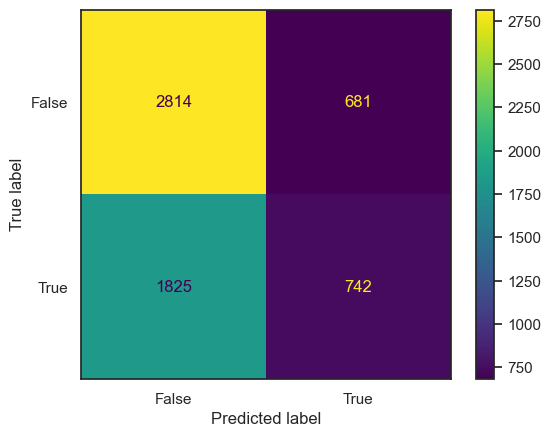

In [122]:
from expected_cost import ec, utils
from expected_cost.data import create_scores_for_expts
from expected_cost.calibration import calibration_with_crossval, calibration_train_on_heldout
from expected_cost.psrcal_wrappers import Brier, LogLoss
from psrcal.calibration import AffineCalLogLoss, AffineCalBrier, HistogramBinningCal

targets = y_eval_binary
scores = clf.predict_proba(X_eval)
costs = ec.CostMatrix([[0, 1.5], [1, -0.05]])
decisions, _ = ec.bayes_decisions(scores, costs, score_type='posteriors')

ConfusionMatrixDisplay.from_predictions(targets,decisions)

### Calibracion

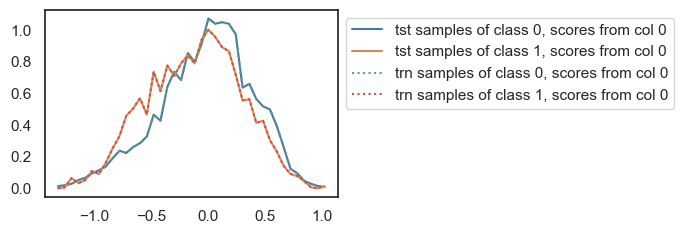

In [88]:
N_trn = int(len(X_eval)*0.7)
deploy_priors = None
scores_tst = scores #scores[N_trn:]
scores_trn = scores #scores[:N_trn]

targets_tst = np.array(targets).astype(int) #np.array(targets[N_trn:]).astype(int)
targets_trn = np.array(targets).astype(int) #np.array(targets[:N_trn]).astype(int)

log_odds_tst = scores_tst[:,:-1]-scores_tst[:,-1][:,np.newaxis]
log_odds_trn = scores_trn[:,:-1]-scores_trn[:,-1][:,np.newaxis]

group_by = 'all' 
axs = utils.plot_hists(targets_tst, log_odds_tst, nbins=40, group_by=group_by, style='-', label_prefix='tst ')
axs = utils.plot_hists(targets_trn, log_odds_trn, nbins=40, group_by=group_by, style=':', label_prefix='trn ', axs=axs)

In [89]:
# Choose EPSR, calibration method, and, optionally, set the priors to the deployment ones
metric = LogLoss 
calmethod = AffineCalLogLoss
use_bias = True
deploy_priors = None
calparams = {'bias': use_bias, 'priors': deploy_priors}

# If you have held-out data or want to do train-on-test 
scores_tst_cal, calmodel = calibration_train_on_heldout(scores_tst, scores_trn, targets_trn, calparams=calparams, 
                                                        calmethod=calmethod, return_model=True)

# Finally, compute the metric before and after calibration
overall_perf = metric(scores_tst, targets_tst, priors=deploy_priors, norm=True)
overall_perf_after_cal = metric(scores_tst_cal, targets_tst, priors=deploy_priors, norm=True)
cal_loss = overall_perf-overall_perf_after_cal
rel_cal_loss = 100*cal_loss/overall_perf

print(f"Overall performance before calibration ({metric.__name__}) = {overall_perf:4.2f}" ) 
print(f"Overall performance after calibration ({metric.__name__}) = {overall_perf_after_cal:4.2f}" ) 
print(f"Calibration loss = {cal_loss:4.2f}" ) 
print(f"Relative calibration loss = {rel_cal_loss:4.1f}%" ) 

Overall performance before calibration (LogLoss) = 1.02
Overall performance after calibration (LogLoss) = 0.99
Calibration loss = 0.03
Relative calibration loss =  3.0%


## Resultados

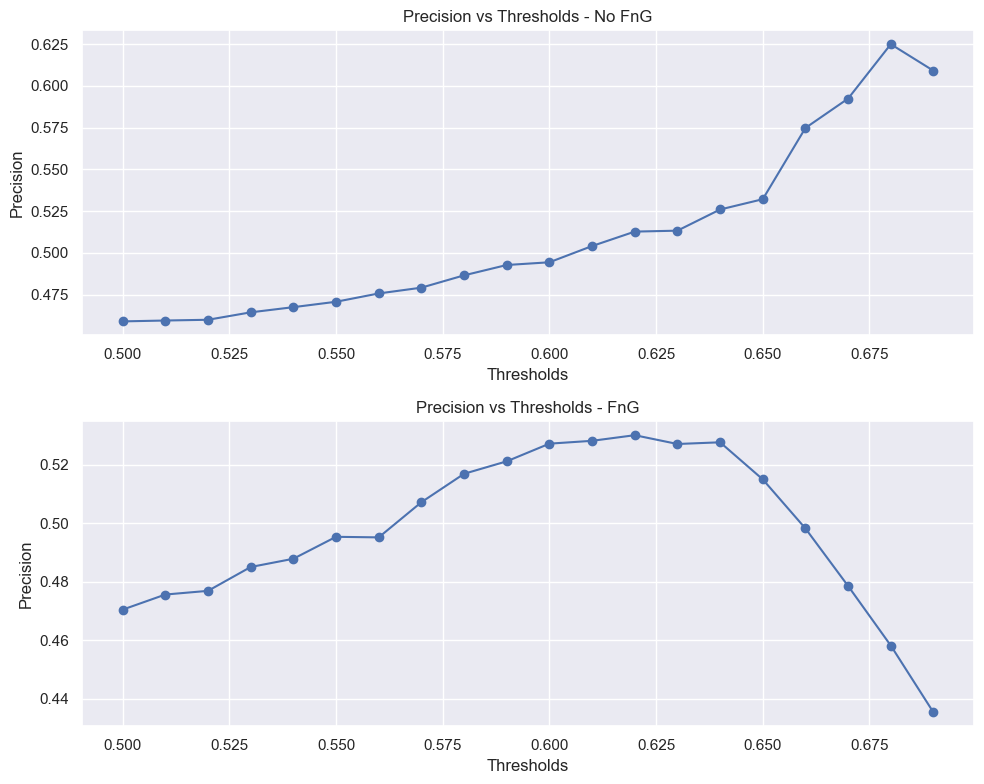

In [5]:
clf, _ = load('./clasificadores/clf_1.joblib')
clf_fng = load('./clasificadores/clf_fng.joblib')
thrs = [i/100 for i in range(50,70)]

probas = clf.predict_proba(X_eval)[:,1]
probas_fng = clf_fng.predict_proba(X_eval_fng)[:,1]
preds, preds_fng = zip(*[(probas > t, probas_fng > t) for t in thrs])
prec, prec_fng = zip(*[(precision_score(y_eval_binary, probas > t), precision_score(y_eval_binary, probas_fng > t)) for t in thrs])


fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot for prec
axs[0].plot(thrs, prec, marker='o', linestyle='-')
axs[0].set_title('Precision vs Thresholds - No FnG')
axs[0].set_xlabel('Thresholds')
axs[0].set_ylabel('Precision')

# Plot for prec_fng
axs[1].plot(thrs, prec_fng, marker='o', linestyle='-')
axs[1].set_title('Precision vs Thresholds - FnG')
axs[1].set_xlabel('Thresholds')
axs[1].set_ylabel('Precision')

plt.tight_layout()

# Show the plots
plt.show()

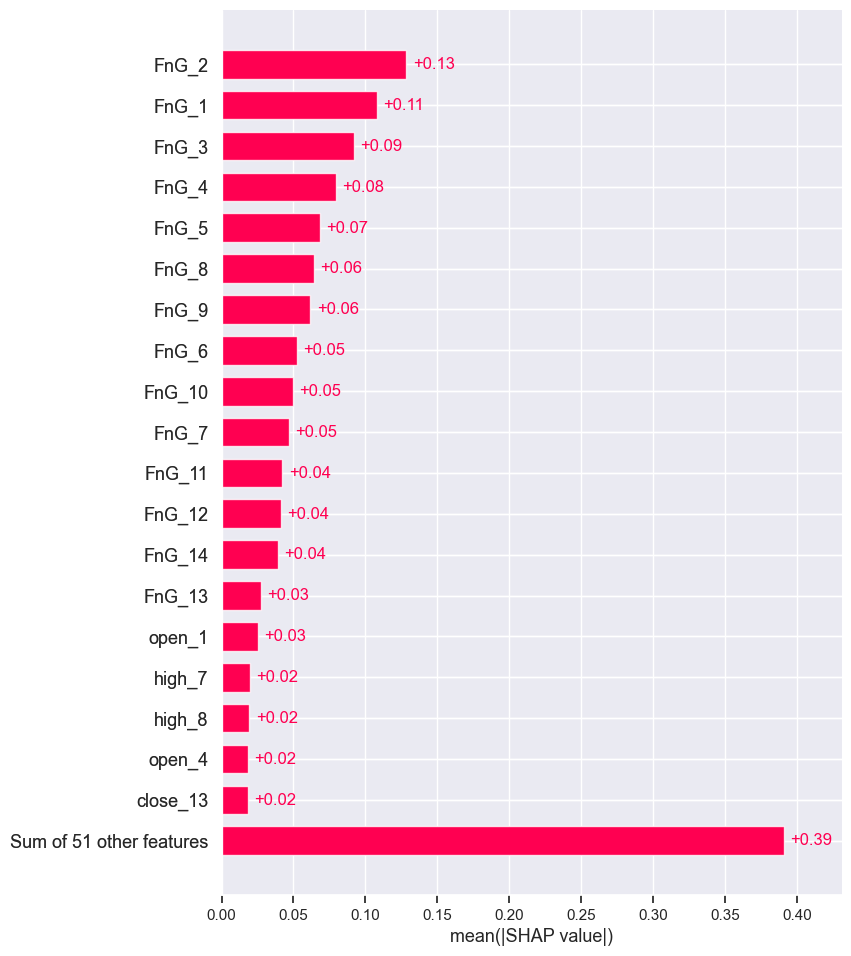

(6062, 70)

In [66]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_eval)
explainer_fng = shap.TreeExplainer(clf_fng)
shap_values_fng = explainer_fng(X_eval_fng)


shap.plots.bar(shap_values_fng, max_display=20)
#shap.plots.bar(shap_values_fng[0])
#shap.plots.waterfall(shap_values_fng[0])
X_eval_fng.shape

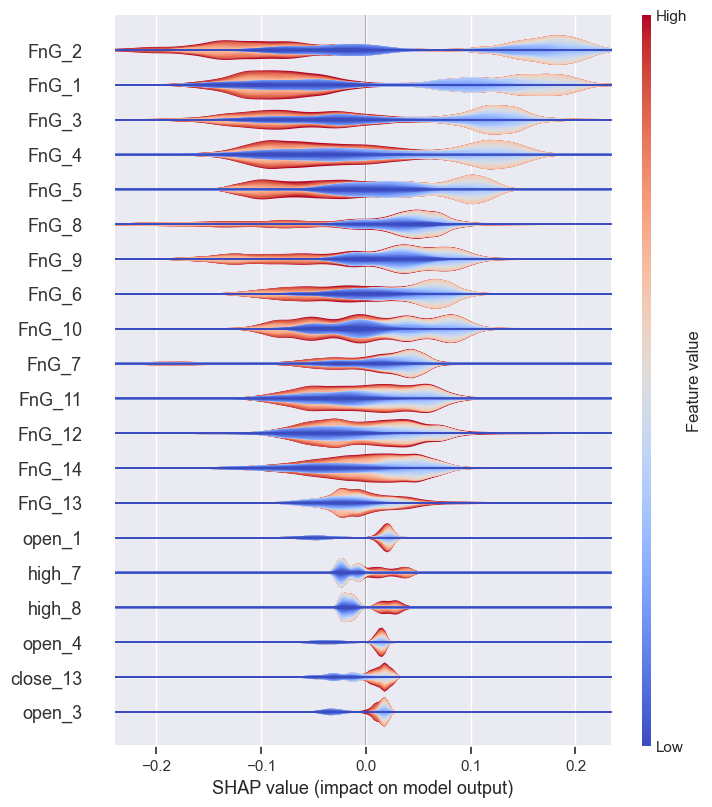

In [26]:
feat_names = list(X_eval_fng.columns)

shap.plots.violin(
    shap_values_fng, features=X_eval_fng, feature_names=feat_names, plot_type="layered_violin"
)
#shap.plots.beeswarm(shap_values_fng)

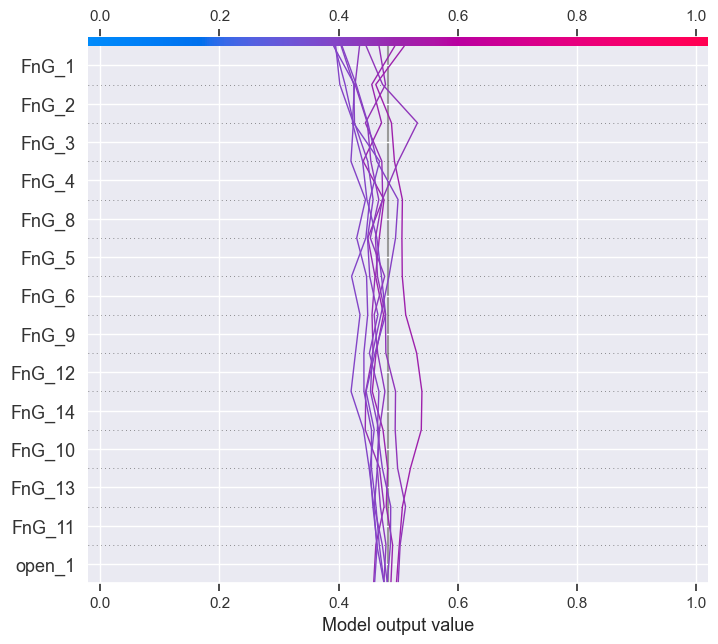

In [73]:
#shap.force_plot(explainer_fng.expected_value, shap_values_fng.values[0, :], X_eval_fng.iloc[0, :], link='logit')
#
shap.decision_plot(explainer_fng.expected_value, shap_values_fng.values[:10, :], X_eval_fng.iloc[:10, :], feature_display_range=slice(None, -15, -1), link='logit')

## Otro

In [ ]:
# Define the parameter grid
import xgboost as xgb

space  = [Real(0.5,1,'log-uniform', name='subsample'),
          Integer(1,100, name='scale_pos_weight'),
          Real(100,300,'uniform', name='reg_lambda'),
          Real(75,150,'uniform', name='reg_alpha'),
          Real(1.0,10.0,'uniform', name='min_child_weight'),
          Integer(2,5, name='max_depth'),
          Real(1e-3,1,'log-uniform', name='decay'),
          Real(0.05,0.3,'uniform', name='initial_lr')
         ]

dtrain = xgb.DMatrix(X_dev, label=y_dev_binary)
dtest = xgb.DMatrix(X_eval, label=y_eval_binary)

# Learning rate scheduler
def exp_decay(epoch, k, initial_lr):
    lrate = initial_lr * np.exp(-k * epoch)
    return lrate

def time_based_decay(epoch, decay, initial_lr):
    lrate = initial_lr * 1 / (1 + decay * epoch)
    return lrate

def eval_params(**params):
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    decay = params.pop('decay')
    initial_lr = params.pop('initial_lr')
    callbacks = [xgb.callback.LearningRateScheduler(lambda epoch: time_based_decay(epoch, decay, initial_lr))]
    cv_results = xgb.cv(params, dtrain, num_boost_round=200, nfold=tscv.get_n_splits(), folds=list(tscv.split(X_dev)), 
                        callbacks=callbacks, early_stopping_rounds=15, shuffle=False, seed=42)
    return cv_results

@use_named_args(space)
def objective_fn(**params):
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    decay = params.pop('decay')
    initial_lr = params.pop('initial_lr')
    callbacks = [xgb.callback.LearningRateScheduler(lambda epoch: time_based_decay(epoch, decay, initial_lr))]
    cv_results = xgb.cv(params, dtrain, num_boost_round=200, nfold=tscv.get_n_splits(), folds=list(tscv.split(X_dev)), 
                        callbacks=callbacks, early_stopping_rounds=15, shuffle=False, seed=42)
    best_auc = np.max(cv_results['test-auc-mean'])
    return -best_auc

param_names = [dim.name for dim in space]
start = time.time()
res_gp = gp_minimize(objective_fn, space, n_calls=30, random_state=42, n_jobs=-1)
print(f"Total time: {(time.time()-start)/60:.2f}m")

optimal_params = dict(zip(param_names, res_gp.x))
optimal_score = -res_gp.fun
cv_res = eval_params(**optimal_params)
optimal_boosting_rounds = np.argmax(cv_res['test-auc-mean']) + 1
decay, initial_lr = optimal_params.pop('decay'), optimal_params.pop('initial_lr')

print(f"Params: {optimal_params}")
print(f"AUC: {optimal_score:.4f}")

In [ ]:
lr_callback = xgb.callback.LearningRateScheduler(lambda epoch: time_based_decay(epoch, decay, initial_lr))
optimal_params['objective'] = 'binary:logistic'
optimal_params['eval_metric'] = 'auc'
clf = xgb.train(params=optimal_params, dtrain=dtrain, num_boost_round=optimal_boosting_rounds, callbacks=[lr_callback])

y_probas = clf.predict(dtest)
print(roc_auc_score(y_eval_binary, y_probas))

precision, recall, thresholds = precision_recall_curve(y_eval_binary, y_probas)

sns.set_theme()
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()